In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Setup

In [2]:
# Load annotation (S-phase label & clone)
df = pd.read_csv('../annotation/annotation_mESC/nuclei_mESC_sphase_all.tsv', sep='\t')
dfSubset = pd.read_csv('../annotation/annotation_mESC/nuclei_mESC_sphase_subset.tsv', sep='\t').set_index('original_index')

genotypes = ['Rif1 WT/WT', 'Rif1 TgWT/flox', 'Rif1 dPP1/flox', 'Rif1 flox/flox', 'Rif1 WT/WT (+OHT)', 'Rif1 TgWT/-', 'Rif1 dPP1/-', 'Rif1 -/-'] 
labels_arr = np.array(df['sphase'])
samples_arr = np.array(df['sample'])

# Load embeddings and center
embeddings_arr = np.load('embeddings/embeddings_BYOL_mESC_all.npy', allow_pickle=True)
scaler = StandardScaler(with_mean=True, with_std=False)
X_centered = scaler.fit_transform(embeddings_arr)

# Run PCA
pca = PCA(n_components=2, random_state=42)
X_emb = pca.fit_transform(X_centered)
var1, var2 = pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]

# Set general plotting parameters
legend_labl = ['early', 'early-mid', 'mid', 'mid-late', 'late']
s = 5 ; alpha = 0.5; markerscale = 2  

### PCA plot (full dataset)

In [3]:
xlabl, ylabl = f'PC1 ({100*var1:.1f}%)', f'PC2 ({100*var2:.1f}%)'
xlim_left, xlim_right, ylim_down, ylim_up = -30, 300, -15, 40     

fig, ax = plt.subplots()

groups = pd.DataFrame(X_emb, columns=['x', 'y']).assign(category=labels_arr).groupby('category') 
for name, points in groups:
    ax.scatter(points.x, points.y, label=name, cmap='Spectral', s=s, alpha=alpha) 
    
ax.legend(legend_labl, markerscale=markerscale)
ax.set_xlabel(xlabl); ax.set_ylabel(ylabl)
ax.set_xlim(xlim_left, xlim_right); ax.set_ylim(ylim_down, ylim_up);  

### PCA plot (magnified)

In [4]:
xlabl, ylabl = 'PC1', 'PC2'           
xlim_left, xlim_right, ylim_down, ylim_up = -14, -13, -5, 0   

fig, ax = plt.subplots()

groups = pd.DataFrame(X_emb, columns=['x', 'y']).assign(category=labels_arr).groupby('category') 
for name, points in groups:
    ax.scatter(points.x, points.y, label=name, cmap='Spectral', s=s, alpha=alpha) 
    
ax.legend(legend_labl, markerscale=markerscale)
ax.set_xlabel(xlabl); ax.set_ylabel(ylabl)
ax.set_xlim(xlim_left, xlim_right); ax.set_ylim(ylim_down, ylim_up);  

## Plots by genotype
- KDE plots
- Scatter plots (by label)
- Scatter plots (by clone)

In [5]:
legend_labl_sphase = ['early', 'early-mid', 'mid', 'mid-late', 'late']
legend_labl_sample = ['Clone 1', 'Clone 2']
xlabl, ylabl = 'PC1', 'PC2'
xlim_left, xlim_right, ylim_down, ylim_up = -30, 300, -15, 40 
vline_x, hline_y = 50, 15
s = 10; alpha_kde = 0.5; alpha_scatter = 0.5; markerscale = 1.5            

### KDE plots

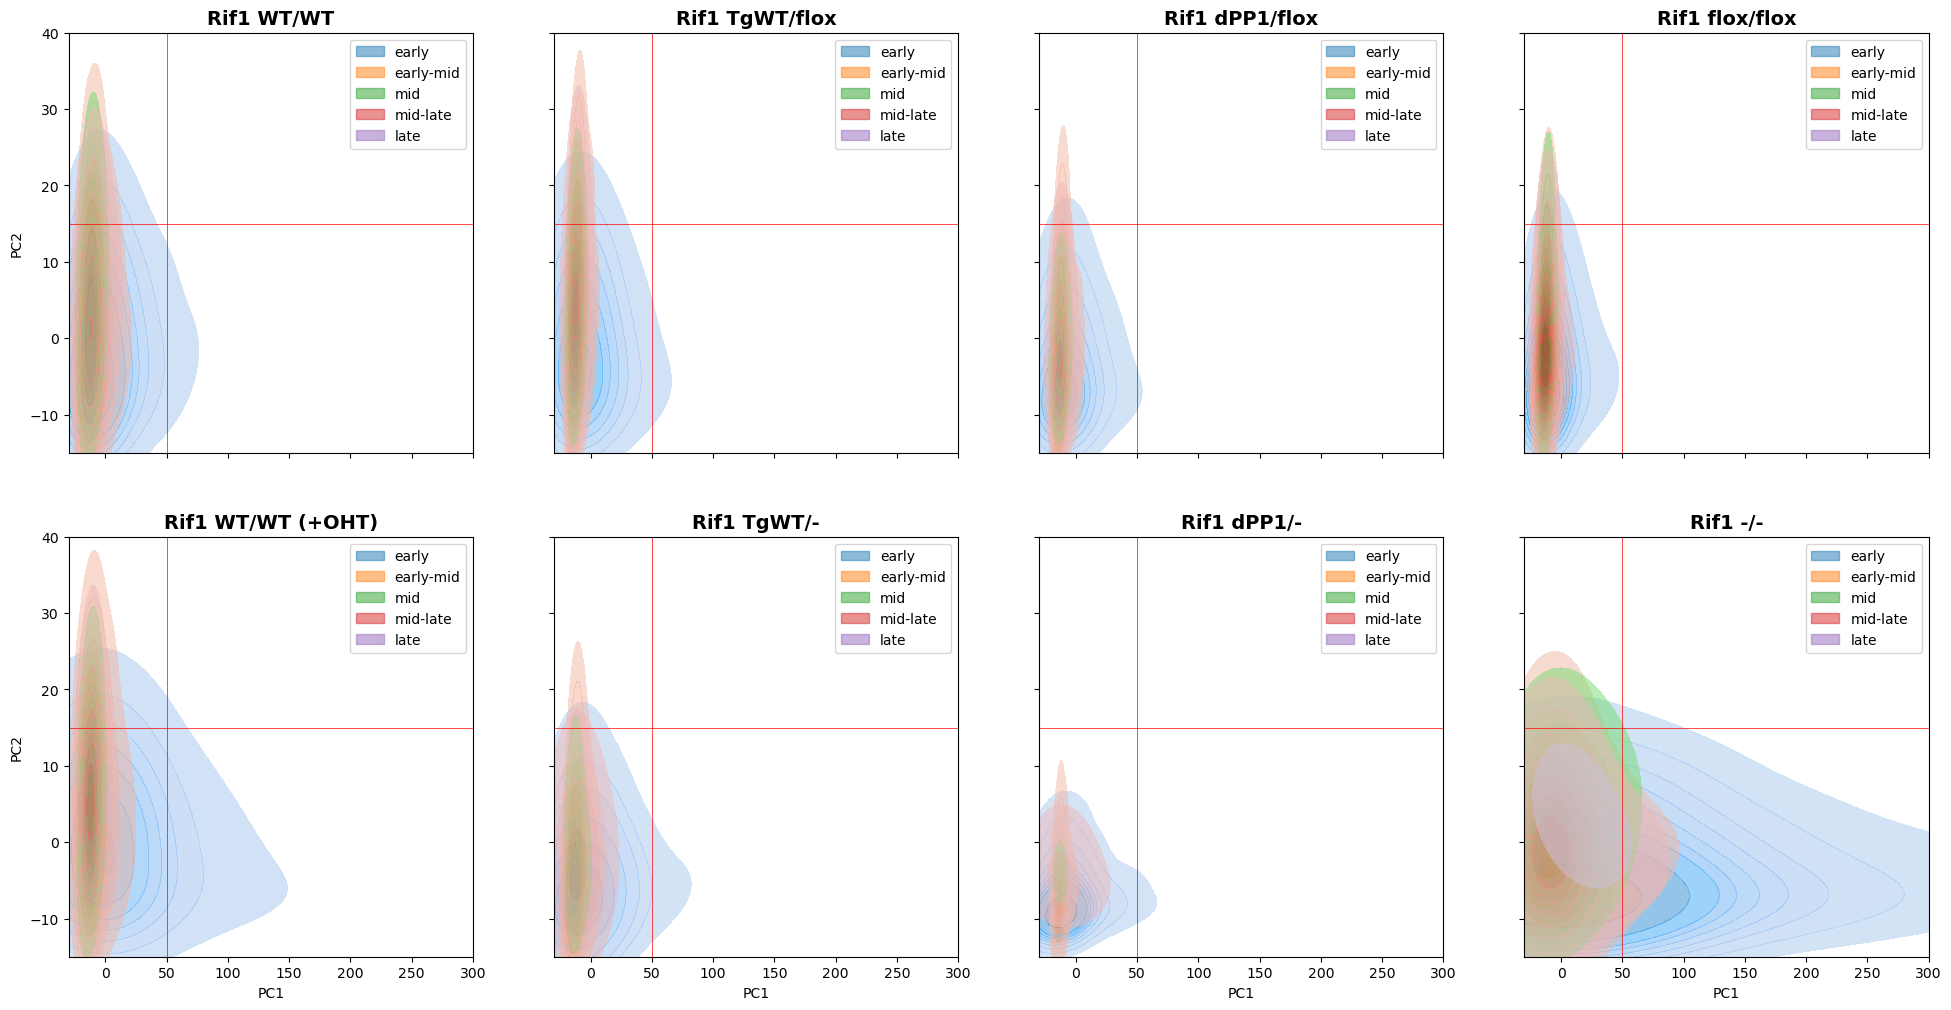

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 12), sharex=True, sharey=True)    

for ax, genotype in zip(axes.flatten(), genotypes):

    # Subset embedding by genotype
    indices1 = df.loc[df['genotype'] == genotype].index
    X_emb1 = X_emb[indices1]
              
    # KDE plots
    data = pd.DataFrame(X_emb1, columns=['x','y'])
    data['label'] = labels_arr[indices1]
    data['label'] = data['label'].map({0: 'early', 1: 'early-mid', 2: 'mid', 3: 'mid-late', 4: 'late'})
    g = sns.kdeplot(data=data, x='x', y='y', hue='label', hue_order=['early', 'early-mid', 'mid', 'mid-late', 'late'], palette=['C0', 'C1', 'C2', 'C3', 'C4'], 
                bw_adjust=2, levels=10, thresh=0.1, alpha=alpha_kde, fill=True, ax=ax)
    
    # Adjust legend
    g.legend_.set_title(None)
    for lh in g.legend_.legendHandles: 
        lh.set_alpha(0.5)

    ax.set_title(genotype, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabl); ax.set_ylabel(ylabl)
    ax.set_xlim(xlim_left, xlim_right); ax.set_ylim(ylim_down, ylim_up) 
    ax.axhline(y = hline_y, color = 'red', linestyle = '-', linewidth = 0.5)
    ax.axvline(x = vline_x, color = 'red', linestyle = '-', linewidth = 0.5)

### Scatter plots (by label)

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 12), sharex=True, sharey=True)    

for ax, genotype in zip(axes.flatten(), genotypes):

    # Subset embedding by genotype (use subset)  
    indices1 = dfSubset.loc[dfSubset['genotype'] == genotype].index
    X_emb1 = X_emb[indices1]
    
    # Scatter plots        
    groups = pd.DataFrame(X_emb1, columns=['x', 'y']).assign(category=labels_arr[indices1]).groupby('category') 
    for label, points in groups:
        ax.scatter(points.x, points.y, label=label, cmap='Spectral', s=s, alpha=alpha_scatter)
    
    ax.legend(legend_labl_sphase, markerscale=markerscale) 
    ax.set_title(genotype, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabl); ax.set_ylabel(ylabl)
    ax.set_xlim(xlim_left, xlim_right); ax.set_ylim(ylim_down, ylim_up)
    ax.axhline(y = hline_y, color = 'red', linestyle = '-', linewidth = 0.5)
    ax.axvline(x = vline_x, color = 'red', linestyle = '-', linewidth = 0.5)

### Scatter plots (by clone)

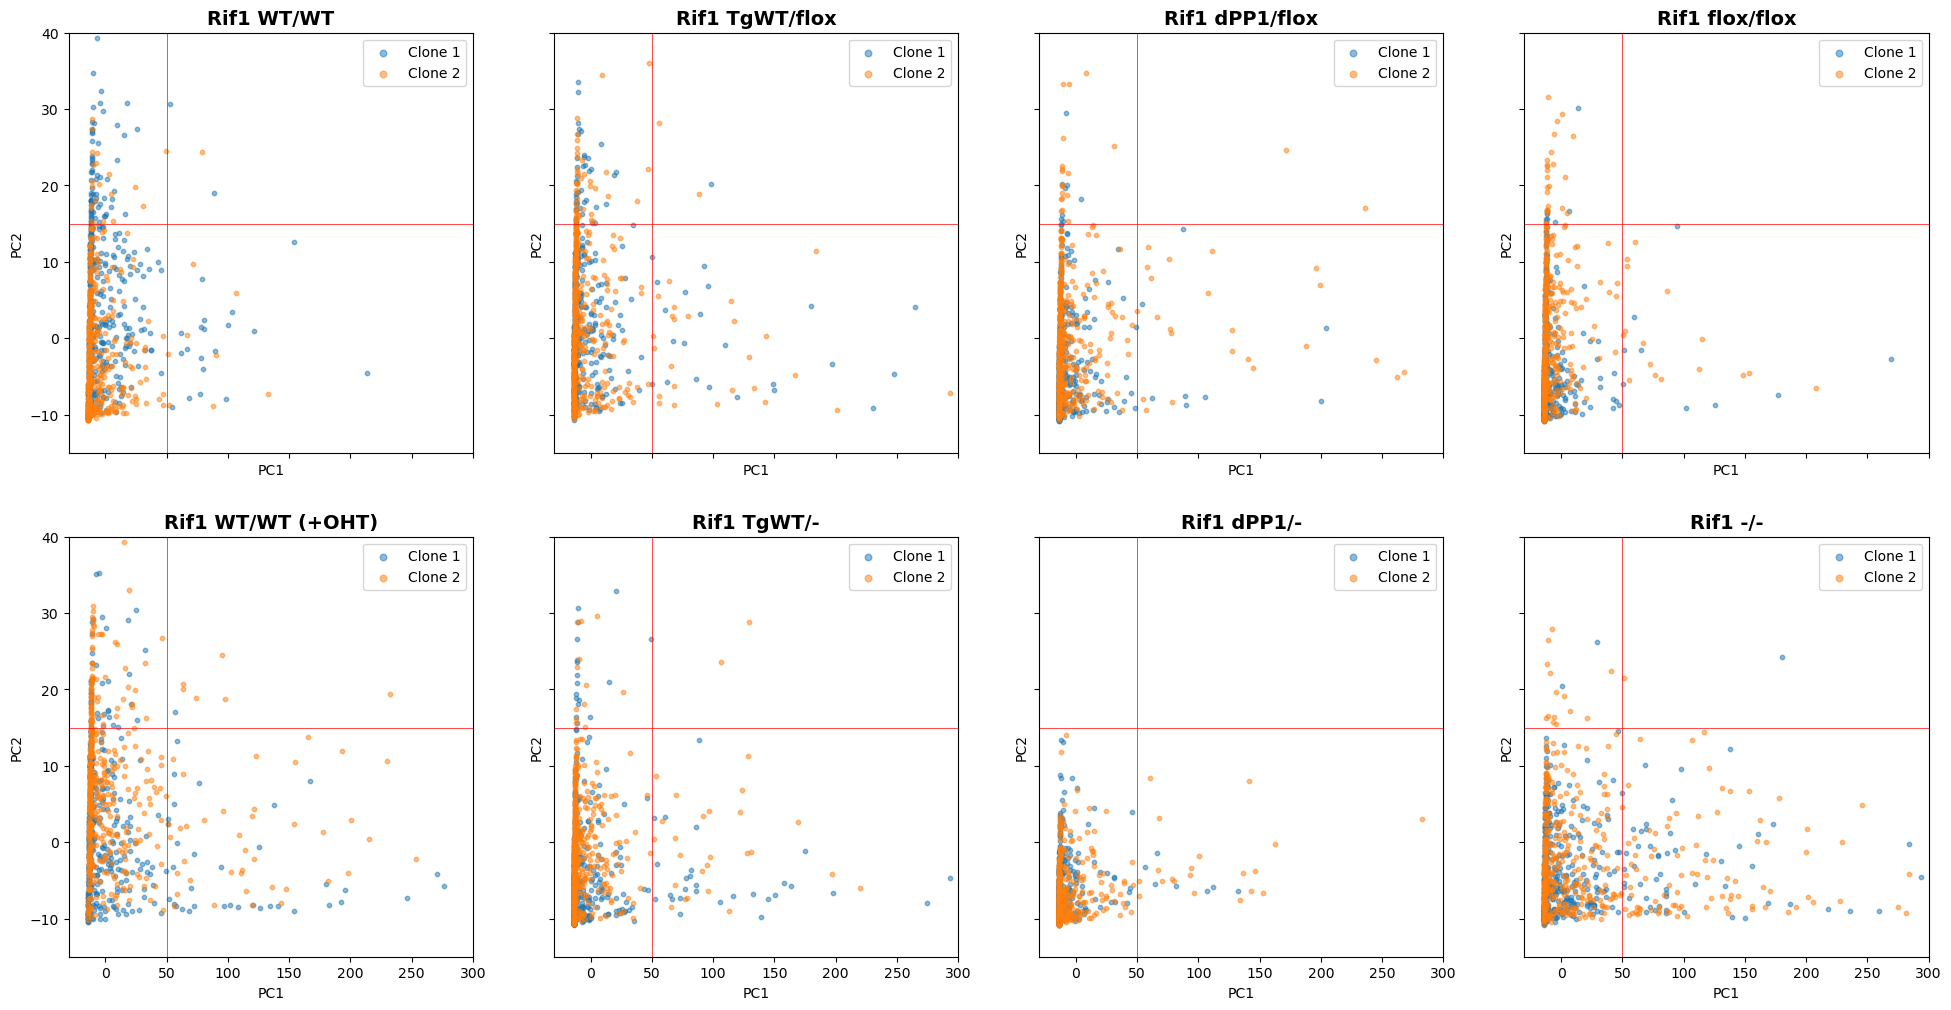

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 12), sharex=True, sharey=True)    

for ax, genotype in zip(axes.flatten(), genotypes):

    # Subset embedding by genotype (use subset)   
    indices1 = dfSubset.loc[dfSubset['genotype'] == genotype].index
    X_emb1 = X_emb[indices1]
        
    # Scatter plots         
    groups = pd.DataFrame(X_emb1, columns=['x', 'y']).assign(category=samples_arr[indices1]).groupby('category') 
    for label, points in groups:
        ax.scatter(points.x, points.y, label=label, cmap='Spectral', s=s, alpha=alpha_scatter)
    ax.legend(legend_labl_sample, markerscale=markerscale) 

    ax.set_title(genotype, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabl); ax.set_ylabel(ylabl)
    ax.set_xlim(xlim_left, xlim_right); ax.set_ylim(ylim_down, ylim_up)
    ax.axhline(y = hline_y, color = 'red', linestyle = '-', linewidth = 0.5)
    ax.axvline(x = vline_x, color = 'red', linestyle = '-', linewidth = 0.5)